In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import random

In [2]:
os.getcwd()

'/kaggle/working'

In [3]:
root_dir = '/kaggle/input/utkface-new/UTKFace'

images = os.listdir(root_dir)

In [4]:
# random_images = random.sample(images, 10000)
random_images = images

In [5]:
def classify_age(age):
    if age <= 12:
        return 0 # 'Child'
    elif age <= 18:
        return 1 # 'Adolescent'
    elif age <= 35:
        return 2 # 'Young Adult'
    elif age <= 59:
        return 3 # 'Adult'
    else:
        return 4 # 'Senior'

In [6]:
ages = np.array([classify_age(int(image.split('_')[0])) for image in random_images])

In [7]:
IMAGE_SIZE = (100, 100)

def load_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=1)
  image = tf.image.resize(image, IMAGE_SIZE)
  image = tf.cast(image, tf.float32) / 255.0

  return image

In [8]:
images_loaded = []

for image in random_images:
  images_loaded.append(load_image(root_dir + '/' + image))

In [9]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced', # Calcula pesos balanceados
    classes=np.unique(ages), # As classes são únicas no array de rótulos
    y=ages # Array de rótulos
)

# Converter para um dicionário de pesos para passar ao modelo
class_weight_dict = dict(enumerate(class_weights))

print("Pesos das classes:", class_weight_dict)

Pesos das classes: {0: 1.3892762965133314, 1: 4.382255083179298, 2: 0.4468149264983038, 3: 0.8021654542378616, 4: 1.7626765799256505}


In [10]:
X = np.array(images_loaded)
y = tf.keras.utils.to_categorical(ages, num_classes=5) # One-hot encode dos rótulos

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

In [27]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(132, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 49, 49, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 23, 23, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 10, 10, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 4, 4, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 132)            │        33,924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           665 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,429 (1.61 MB)

 Trainable params: 422,429 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=100, 
    batch_size=32,
#     class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy')]
)

Epoch 1/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.4353 - loss: 1.4025 - val_accuracy: 0.4473 - val_loss: 1.3245
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4532 - loss: 1.3287 - val_accuracy: 0.4702 - val_loss: 1.2954
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4699 - loss: 1.2808 - val_accuracy: 0.4881 - val_loss: 1.2471
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4944 - loss: 1.2239 - val_accuracy: 0.5595 - val_loss: 1.0994
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5591 - loss: 1.0890 - val_accuracy: 0.5801 - val_loss: 1.0211
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5884 - loss: 1.0245 - val_accuracy: 0.6062 - val_loss: 0.9830
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6025 - loss: 0.9907 - val_accuracy: 0.6145 - val_loss: 0.9668
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6115 - loss: 0.9673 -

In [29]:
predictions = model.predict(X_test)

178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


              precision    recall  f1-score   support

           0       0.93      0.84      0.88       830
           1       0.29      0.15      0.20       235
           2       0.73      0.86      0.79      2547
           3       0.59      0.52      0.55      1448
           4       0.71      0.59      0.64       630

    accuracy                           0.71      5690
   macro avg       0.65      0.59      0.61      5690
weighted avg       0.70      0.71      0.70      5690



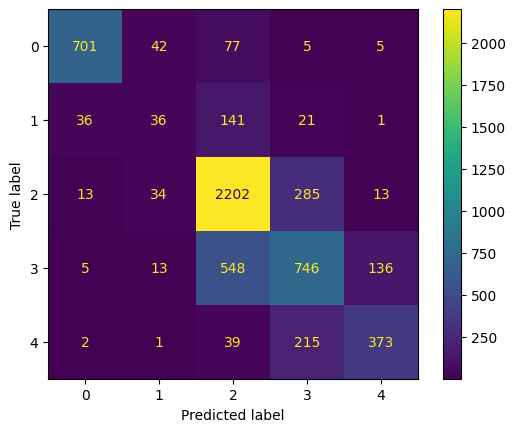

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report([y.argmax() for y in y_test], [prediction.argmax() for prediction in predictions]))

cm = confusion_matrix([y.argmax() for y in y_test], [prediction.argmax() for prediction in predictions])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [33]:
model.export('age_model_export')

Saved artifact at 'age_model_export'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140103781821680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140103781823968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140103781813408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140103781824496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140085597607488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140085597614528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140085597602736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140085597616640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140085597606256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140085597617344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14008559760

In [32]:
!zip -r age_model_export.zip /kaggle/working/age_model_export

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/age_model_export/ (stored 0%)
  adding: kaggle/working/age_model_export/fingerprint.pb (stored 0%)
  adding: kaggle/working/age_model_export/assets/ (stored 0%)
  adding: kaggle/working/age_model_export/variables/ (stored 0%)
  adding: kaggle/working/age_model_export/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/age_model_export/variables/variables.index (deflated 63%)
  adding: kaggle/working/age_model_export/saved_model.pb (deflated 86%)
